In [56]:
import sys

sys.path.append('../')
from networks import ConditionGenerator
from train_condition import get_opt

import os
from PIL import Image

import torch
from torch import nn
import numpy as np

import lovely_tensors as lt
lt.monkey_patch()

opt = get_opt()

In [2]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms

from PIL import Image, ImageDraw
import json

from pathlib import Path

import os.path as osp
import numpy as np


In [ ]:
class CPDataset(data.Dataset):
    def __init__(self, opt):
        super(CPDataset, self).__init__()
        self.opt = opt
        self.root = opt.dataroot
        self.datamode = opt.datamode # train or test or self-defined
        self.data_list = opt.data_list
        self.fine_height = opt.fine_height
        self.fine_width = opt.fine_width
        self.semantic_nc = opt.semantic_nc
        self.data_path = osp.join(opt.dataroot, opt.datamode)
        self.transform = transforms.Compose([  \
                transforms.ToTensor(),   \
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        im_names = []
        c_names = []
        with open(osp.join(opt.dataroot, opt.data_list), 'r') as f:
            for line in f.readlines():
                im_name, c_name = line.strip().split()
                im_names.append(im_name)
                c_names.append(c_name)

        self.im_names = Path('/home/aiteam/tykim/generative_model/human/HR-VITON/data/imgs').rglob('*[!_r].png')
        
        self.im_names = im_names
        self.c_names = dict()
        self.c_names['paired'] = im_names
        self.c_names['unpaired'] = c_names

        
    def __len__(self):
        return len(self.im_names)
    
    def __getitem__(self, index):
        im_name = self.im_names[index]
        im_name = 'image/' + im_name
        c_name = {}
        c = {}
        cm = {}
        for key in ['paired']:
            c_name[key] = self.c_names[key][index]
            c[key] = Image.open(osp.join(self.data_path, 'cloth', c_name[key])).convert('RGB')
            c[key] = transforms.Resize(self.fine_width, interpolation=2)(c[key])
            cm[key] = Image.open(osp.join(self.data_path, 'cloth-mask', c_name[key]))
            cm[key] = transforms.Resize(self.fine_width, interpolation=0)(cm[key])

        result = {
            'c_name':   c_name,     # for visualization
            'im_name':  im_name,    # for visualization or ground truth
            # intput 1 (clothfloww)
            'cloth':    c,          # for input
            'cloth_mask':     cm,   # for input
            # intput 2 (segnet)
            'parse_agnostic': new_parse_agnostic_map,
            'densepose': densepose_map,
            'pose': pose_map,       # for conditioning
            # generator input
            'agnostic' : agnostic,
            # GT
            'parse_onehot' : parse_onehot,  # Cross Entropy
            'parse': new_parse_map, # GAN Loss real
            'pcm': pcm,             # L1 Loss & vis
            'parse_cloth': im_c,    # VGG Loss & vis
            # visualization & GT
            'image':    im,         # for visualization
            }
        return result

In [3]:
import torchvision.transforms as transforms
dataroot = '/home/aiteam/tykim/generative_model/human/HR-VITON/data/dresscode'

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

transform2D = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, ))])

im_names = []
c_names = []
dataroot_names = []

In [4]:
im_names = list(Path('/home/aiteam/tykim/generative_model/human/HR-VITON/data/dresscode/imgs').rglob('*[!_r]_0.jpg'))

In [5]:
im_names

[Path('/home/aiteam/tykim/generative_model/human/HR-VITON/data/dresscode/imgs/020714_0.jpg')]

In [6]:
c_names = list(Path('/home/aiteam/tykim/generative_model/human/HR-VITON/data/dresscode/imgs').rglob('*[!_r]_1.jpg'))

In [7]:
c_names

[Path('/home/aiteam/tykim/generative_model/human/HR-VITON/data/dresscode/imgs/020714_1.jpg')]

In [8]:
cloth = Image.open(c_names[0])

In [19]:
parse_name = str(im_names[0]).replace('_0.jpg', '_4.png').replace('imgs', 'label_maps')
im_parse = Image.open(parse_name)
im_parse_pil = im_parse.resize((opt.fine_width,  opt.fine_height), Image.NEAREST)


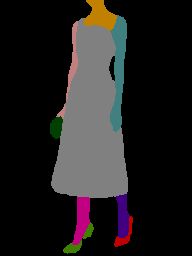

In [20]:
im_parse_pil

In [21]:
im_parse_pil.size, im_parse_pil.mode

((192, 256), 'P')

In [22]:
parse = torch.from_numpy(np.array(im_parse_pil)[None]).long() # [1, 512, 256]

In [23]:
transform = transforms.Compose([  \
                transforms.ToTensor(),   \
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [24]:
im_parse = transform(im_parse_pil.convert('RGB'))

In [25]:
im_parse.shape

torch.Size([3, 256, 192])

In [26]:
opt.fine_height, opt.fine_width

(256, 192)

In [27]:
parse_class = 18 # SCHP의 경우 20이 아니라 18
parse_map = torch.FloatTensor(parse_class, opt.fine_height, opt.fine_width).zero_()

In [28]:
parse_map = parse_map.scatter_(0, parse, 1.0)

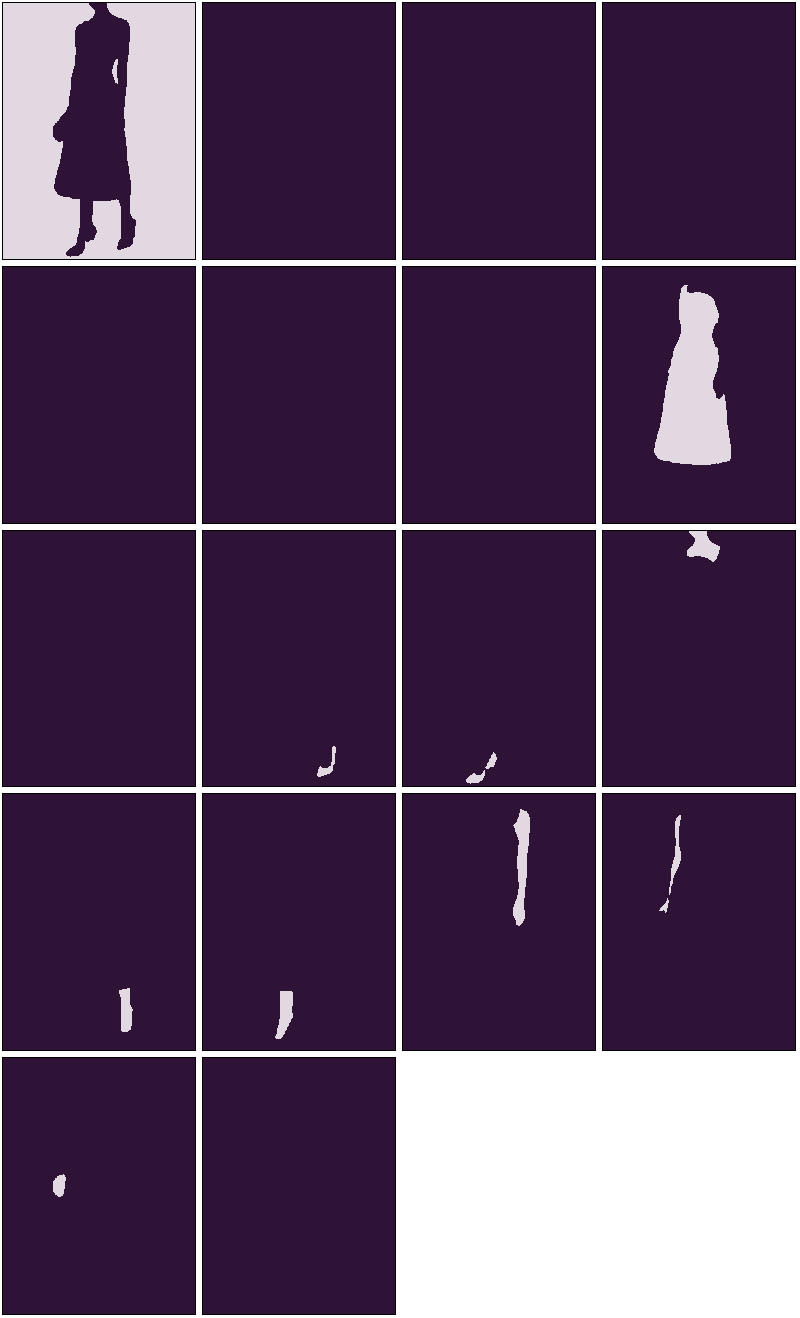

In [30]:
lt.chans(parse_map)

In [44]:
opt.semantic_nc = 15

In [45]:
# 묶는게 맞다. 특정 class는 0인 경우가 허다할 텐데
# 네트워크 학습을 좀 더 효율적으로 하기 위해서 
# [0,..12]인 이유는 opt.semantic_nc=13이라서
labels = {
            0:  ['background',  [0]],
            1:  ['hair',        [1, 2]], # hat, hair
            2:  ['face',        [3, 11]], # sunglasses + head
            3:  ['upper',       [4]], # upper_clothes
            4:  ['bottom',      [5, 6]], # skirt + pants
            5:  ['left_arm',    [14]],
            6:  ['right_arm',   [15]],
            7:  ['left_leg',    [12]],
            8:  ['right_leg',   [13]],
            9:  ['left_shoe',   [9]],
            10: ['right_shoe',  [10]],
            11: ['belt',       [8]], # belt
            12: ['bag',        [16]],
            13: ['dress' ,     [7]],
            14: ['scarf',      [17]],
        }

In [46]:
new_parse_map = torch.FloatTensor(opt.semantic_nc, opt.fine_height, opt.fine_width).zero_()

In [47]:
for i in range(len(labels)):
    for label in labels[i][1]:
        new_parse_map[i] += parse_map[label]

In [48]:
new_parse_map.shape

torch.Size([15, 256, 192])

In [49]:
im_pil_big = Image.open(im_names[0])

In [51]:
im_pil = transforms.Resize(opt.fine_width, interpolation=2)(im_pil_big)
im = transform(im_pil)

/home/aiteam/miniconda3/envs/3dfm/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [52]:
im.shape

torch.Size([3, 256, 192])

In [61]:
# parse cloth & parse cloth mask
# mask를 카테고리마다 따로 얻어야 할듯?
c = 'dresses'
if c == 'upper_body':
    idx = 3
elif c == 'lower_body':
    idx = 4
else:
    idx = 13
    
pcm = new_parse_map[idx:idx+1]
im_c = im * pcm + (1 - pcm)

In [62]:
pcm.v

tensor[1, 256, 192] n=49152 x∈[0., 1.000] μ=0.181 σ=0.385
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [66]:
data_root = '/home/aiteam/tykim/generative_model/human/HR-VITON/data/dresscode'

In [67]:
img_path = os.path.join(data_root, 'imgs')
img_path

'/home/aiteam/tykim/generative_model/human/HR-VITON/data/dresscode/imgs'

In [78]:
data_root

'/home/aiteam/tykim/generative_model/human/HR-VITON/data/dresscode'

In [79]:
in_name = '020714_0.jpg'

In [80]:
uv = np.load(os.path.join(data_root, 'dense', in_name.replace('_0.jpg', '_5_uv.npz')))
uv = uv['uv']
uv = torch.from_numpy(uv)

(2, 1024, 768)

In [ ]:
from torchvision.io import read_image

In [1]:
import cv2

In [18]:
img = cv2.imread('/home/aiteam/tykim/generative_model/human/HR-VITON/data/train/image-parse-v3/00001_00.png', cv2.IMREAD_COLOR)

In [13]:
type(img)

numpy.ndarray

In [14]:
img.shape, img.dtype

((1024, 768, 3), dtype('uint8'))

In [8]:
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

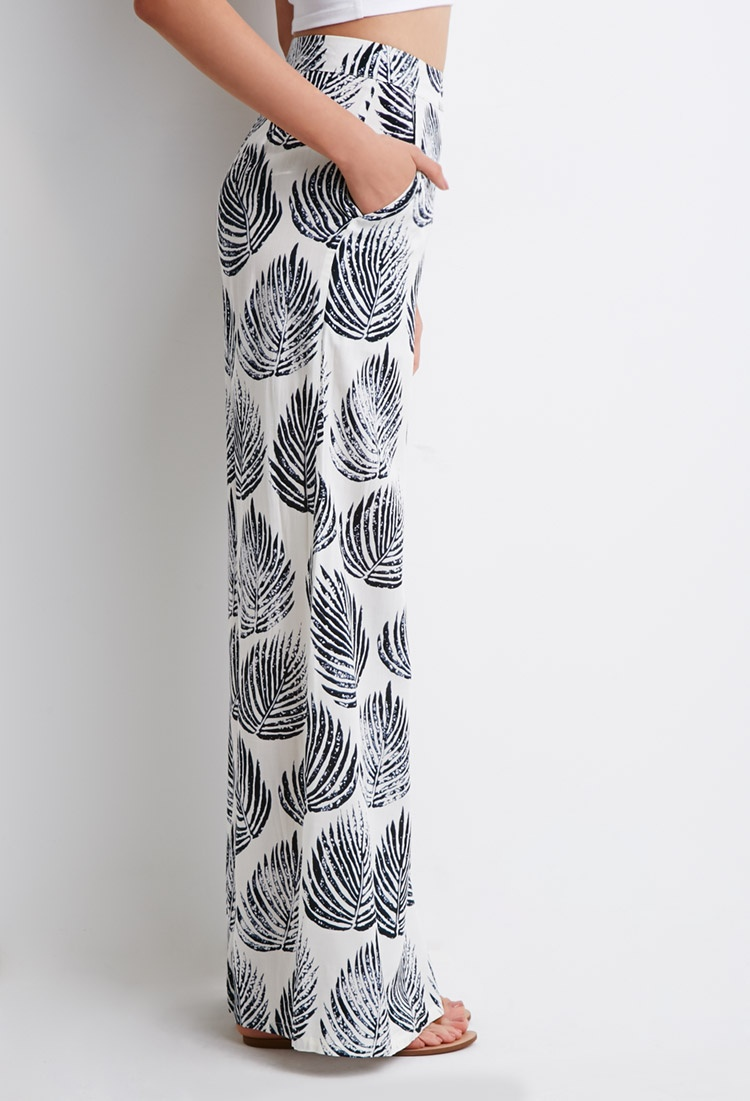

In [10]:
Image.fromarray(RGB_img)

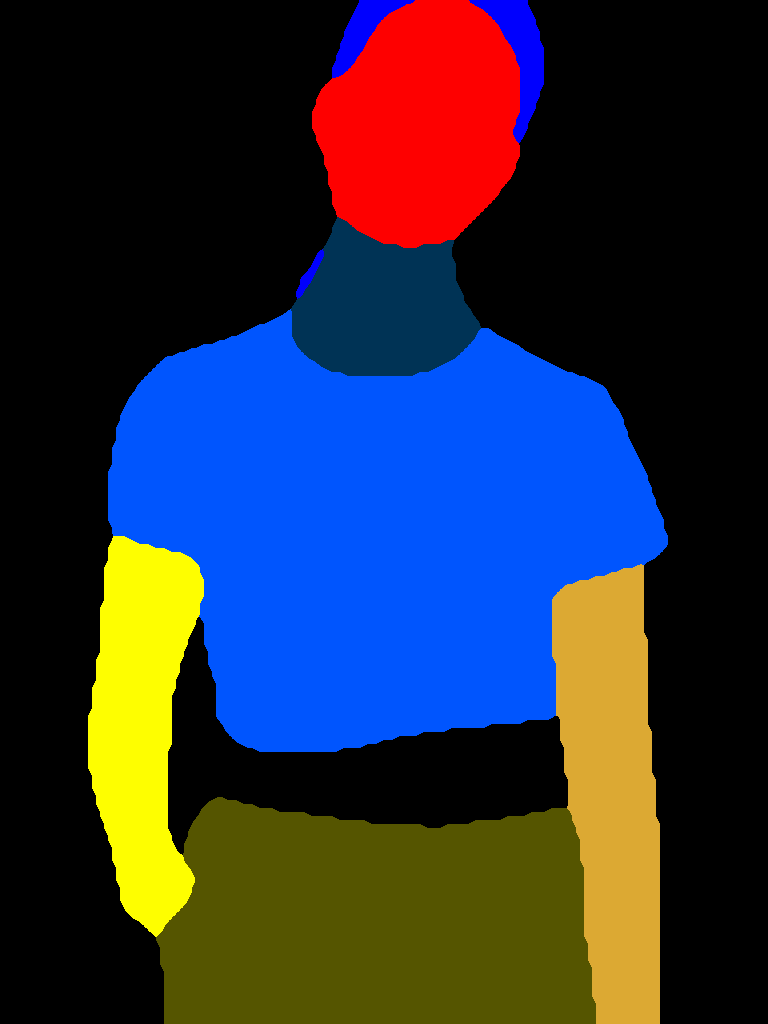

In [15]:
from PIL import Image
Image.fromarray(img)

In [50]:
from torchvision.io import read_image

In [113]:
img = read_image('/home/aiteam/tykim/generative_model/05_1_front.jpg')

In [114]:
img.shape

torch.Size([3, 1101, 750])

In [116]:
img.dtype

torch.uint8

In [80]:
img_np = img.permute(1,2,0).numpy()#.squeeze(0)

In [81]:
img_np.shape, img_np.dtype

((1101, 750, 3), dtype('uint8'))

In [115]:
torch.unique(img)

tensor[256] u8 x∈[0, 255] μ=127.500 σ=74.045

In [83]:
img_pil = Image.fromarray(img_np)

In [ ]:
img_pil

In [85]:
from torchvision.transforms import ToTensor

tt  = ToTensor()




In [86]:
img_tc = tt(img_pil)

In [95]:
img_tc.shape, img_tc.dtype, torch.unique(img_tc*255)

(torch.Size([3, 1101, 750]),
 torch.float32,
 tensor[256] x∈[0., 255.000] μ=127.500 σ=74.045)

In [101]:
import lovely_numpy as ln
ln.monkey_patch()

AttributeError: module 'lovely_numpy' has no attribute 'monkey_patch'

In [109]:
img = torch.randn(1,3,256, 256)
print(type(img), img.shape, img.dtype)

<class 'torch.Tensor'> torch.Size([1, 3, 256, 256]) torch.float32


In [110]:
img = (img + 1.0) / 2.0 * 255.0
np_arr = img.squeeze().permute(1,2,0).clamp(0, 255).to(torch.uint8).numpy()

In [111]:
np_arr.shape, np_arr.dtype

((256, 256, 3), dtype('uint8'))

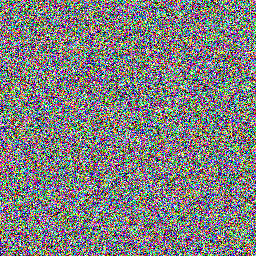

In [112]:
Image.fromarray(np_arr)

In [ ]:
Image.fromarray((img[0].permute(1,2,0)*255))

In [ ]:
np.unique(np.asarray(Image.open('/home/aiteam/tykim/generative_model/05_1_front.jpg')))

In [103]:
np.unique(np.asarray(Image.open('/home/aiteam/tykim/generative_model/05_1_front.jpg')))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

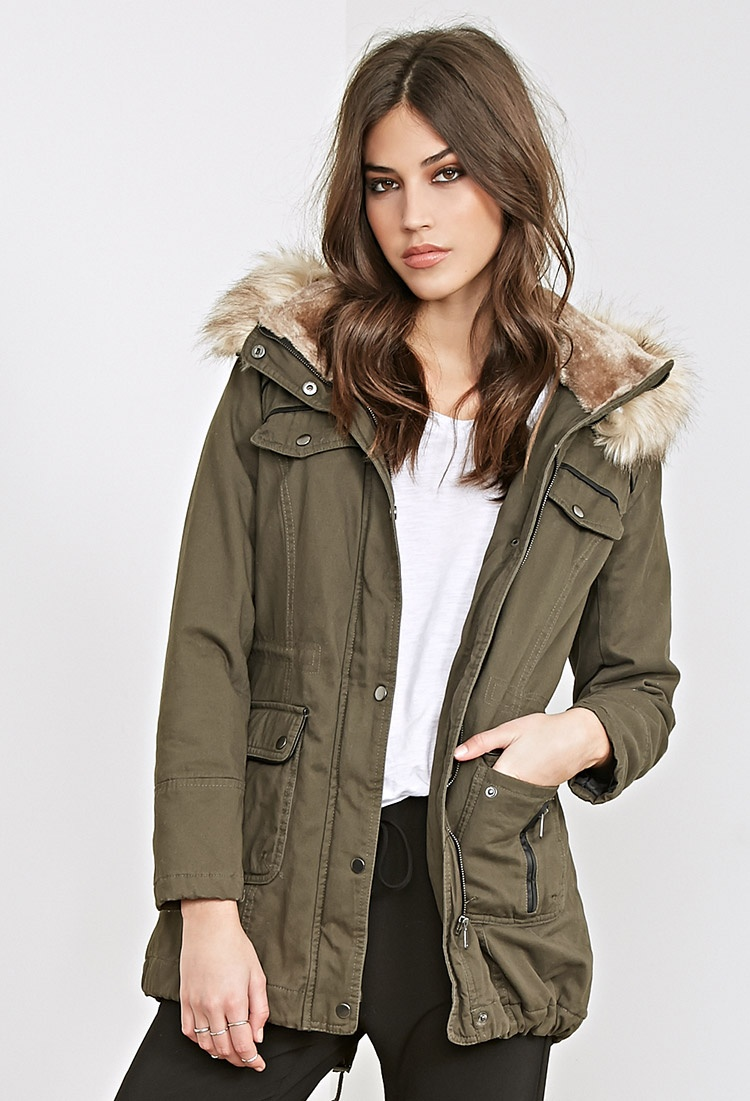

In [97]:
img_pil = Image.fromarray((img_tc*255).permute(1,2,0).numpy().astype(np.uint8))
img_pil

In [72]:
img.dtype

torch.uint8

In [70]:
img_tc.dtype

torch.float32

In [ ]:
lt.rgb(tt(img_pil))

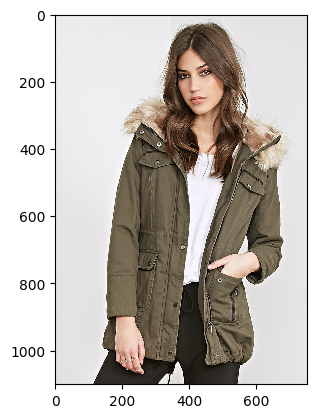

In [53]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1,2,0),interpolation='nearest')


In [60]:
img.shape

torch.Size([3, 1101, 750])

In [ ]:
/home/aiteam/tykim/generative_model/human/HR-VITON/data/train/image-parse-v3/00001_00.png

In [3]:
img = read_image('/home/aiteam/tykim/generative_model/human/HR-VITON/data/train/image-parse-v3/00001_00.png')

In [4]:
type(img)

torch.Tensor

In [5]:
img.shape

torch.Size([1, 1024, 768])

In [12]:
import torch
torch.unique(img)

tensor([ 0,  2,  5,  9, 10, 13, 14, 15], dtype=torch.uint8)

In [33]:
img_np = img.numpy()#.squeeze(0)

In [34]:
img_np.shape, img_np.dtype

((1, 1024, 768), dtype('uint8'))

In [35]:
import numpy as np
np.unique(img_np)

array([ 0,  2,  5,  9, 10, 13, 14, 15], dtype=uint8)

In [36]:
pil_image = Image.fromarray((img_np * 255).astype(np.uint8), mode='P')

ValueError: Too many dimensions: 3 > 2.

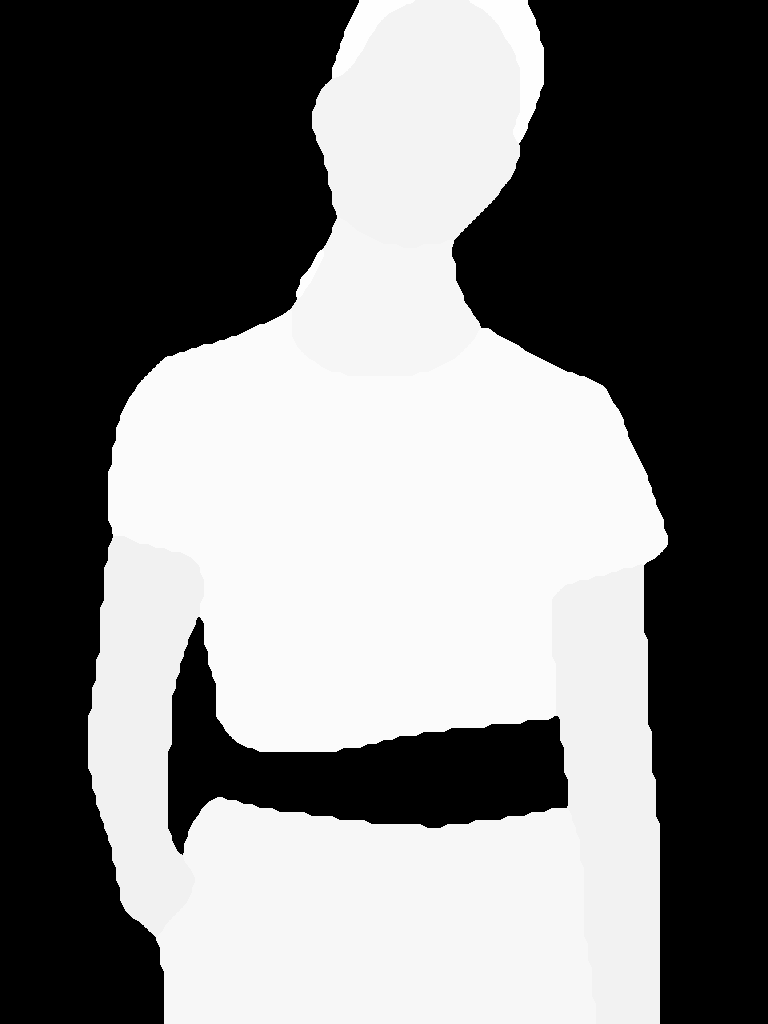

In [37]:
pil_image

In [8]:
import matplotlib.pyplot as plt

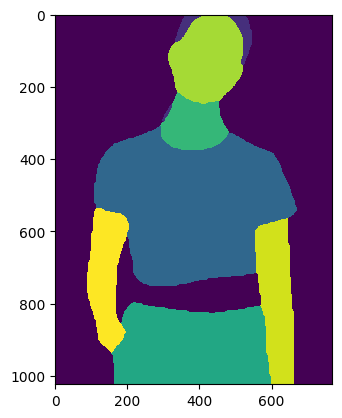

In [9]:
from PIL import Image

# Image.fromarray(img.permute(1,2,0).numpy())

plt.imshow(img.permute(1,2,0),interpolation='nearest')
